# FaceNet

## Purpose
In this notebook, we will analyze the FaceNet implementation. The code is taken from [this](https://github.com/timesler/facenet-pytorch) Github repository. The architecture is applied on the AgeDB dataset, which can be found [here](https://ibug.doc.ic.ac.uk/resources/agedb/).

# Setup

## Library import
We import all the required Python libraries.

In [ ]:
# Core
import torch
from torch.utils.data import DataLoader
from torchvision import datasets

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import data_table
from PIL import Image
sns.set_theme(context='notebook', style='darkgrid', palette='pastel')

# General
import math
import os
from glob import glob
from random import randint

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Repository import
We import all the required repositories. The only one we need at the moment is the [timesler/facenet-pytorch](https://github.com/timesler/facenet-pytorch), as stated above.

In [ ]:
%%bash
git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

Cloning into 'facenet_pytorch'...


## Parameter definition
We set all relevant parameters for our notebook.

In [ ]:
## General
# Set the device to a GPU if available.
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {DEVICE}')
# Set the number of workers depending on the os.
WORKERS = 0 if os.name == 'nt' else 4
print(f'N. of workers: {WORKERS}')

## InceptionResnetV1
# Defines whether to load a model pre-trained on `vggface2` or on
# `casia-webface`. The first one performs a little better (0.9965 on LFW
# compared to 0.9905) and is slightly smaller (107MB compared to 111MB).
PRETRAINED = "vggface2"

## MTCNN
# Define the output image size and margin of the MTCNN module.
IMAGE_SIZE = 160
MARGIN = 0


Running on device: cpu
N. of workers: 4


# Data

## Data import

To evaluate the model, we import the AgeDB dataset, which contains images of faces already cropped. Therefore, we don't need to apply the MTCNN module to detect and align faces.

The instructions to follow to retrieve the AgeDB dataset are [here](https://ibug.doc.ic.ac.uk/resources/agedb/).

To visualize the data easily in tabular form, we can use the following code.

## Data visualization
To visualize the data, we write a some methods. The method `get_annotations` extract from the filename the information about the person, `get_image` retrieve an image at random or at index, `get_images` returns all of the paths of the images of the specified class.

In [ ]:
def get_annotations(img_path):
  """Decompose the filename of an image to get its annotations.
  
    Arguments:
      img_path (string): Path to the image.
    
    Returns:
      annotations (list): Contains (in order) img_id, subject_name, age, gender.
  """
  # Keep only the filename and remove the directories.
  img_name = img_path.split('/')[-1]

  # Remove the extension.
  img_name = img_name[:-4]

  # Get the different notes by splitting on the underscore.
  fields = img_name.split('_')

  # Convert the img_id and the age to integer.
  fields = [int(fields[0]), fields[1], int(fields[2]), fields[3]]

  return fields

def get_image(id=-1):
  """Retrieve an image from the database. If no id is passed, then the image
  is taken at random.

    Arguments:
      id (int): id of the image.
    
    Returns:
      img_path (string): path to the image.
  """

  # Get the list of all of the images.
  images = glob('AgeDB/*.jpg')

  # Check that the index valid.
  assert id <= len(images)

  # If no index, set it randomly.
  if id == -1:
    id = randint(0, len(images))

  # Generate the list of all the indices.
  indices = [get_annotations(image)[0] for image in images]

  # Return the path to the image.
  return images[indices.index(id)]

def get_images(ids=None, class_name=None):
  """Return all of the images of the specified identity.

    Arguments:
      ids (list): ids of the images to retrieve.
      class_name (string): identity of the person.
    
    Returns
      img_paths (list): list of paths to the images.
  """
  img_paths = []

  # If class_name is defined.
  if class_name != None:
    # Get the list of all of the images.
    images = glob('AgeDB/*.jpg')

    # If the path contains the name of the class, then it's an image of the class.
    img_paths = [image for image in images if class_name in image]
  # If ids are defined instead.
  elif ids != None:
    # Get the list of paths with the get_image method.
    img_paths = [get_image(id) for id in ids]

  return img_paths


The code below is used to show a single image specified by index or path, or taken at random.

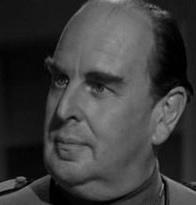

In [ ]:
def show_image(id=None, img_path=None):
  """Show an image. If no path to an image or id is passed, then the image is
  retrieved at random.

    Arguments:
      id (int): id of the image to show.
      img_path (string): path to an image.
    
    Returns:
      img (JpegImageFile): image in JPG format.
  """

  # If no path to image, check the id.
  if img_path == None:
    # If no id, get a random one.
    if id == None:
      img_path = get_image()
    else:
      img_path = get_image(id=id)
  
  # Return a JpegImageFile
  return Image.open(img_path)

show_image()


Moreover, we write another method to show a batch of faces with their information. If we don't pass any 

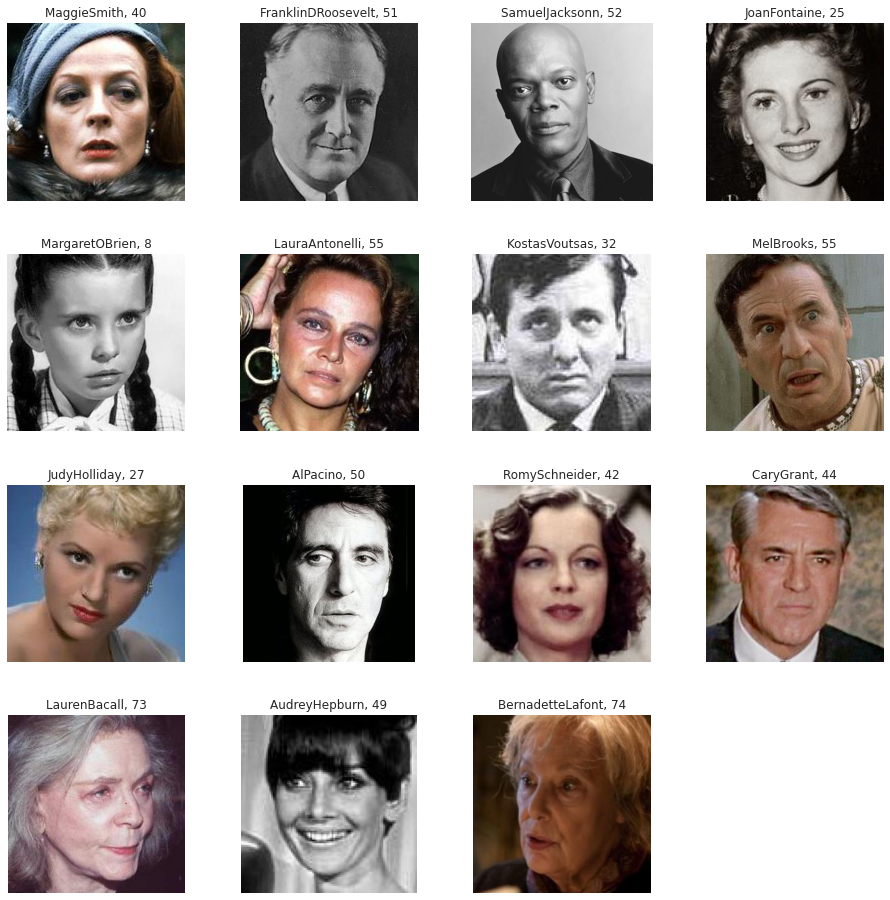

In [ ]:
def show_images(ids=None, img_paths=None, n=9,
                extra_info=None, show_title=True):
  """Show a batch of images.

    Arguments:
      ids (list): 
      img_paths (list):
      n (int): total number of images to show. If ids or paths are passed, it
        is automatically evaluated.
      show_title (bool): add name and age of person as title to each image.
      extra_info (list): add extra line of information in the title of each
        image. The dimension of the list must match either the dimension of the
        ids or the img_paths.
  """

  # If the ids or the paths to the images are passed, overwrite the value of
  # size.
  if ids != None:
    size = math.ceil(math.sqrt(len(ids)))
    stop = len(ids) + 1
  elif img_paths != None:
    size = math.ceil(math.sqrt(len(img_paths)))
    stop = len(img_paths) + 1
  else:
    size = math.ceil(math.sqrt(n))
    stop = n + 1

  # Create a new figure.
  fig = plt.figure(figsize=(size*4, size*4))

  # Set the horizontal space between subplots.
  plt.subplots_adjust(hspace=0.3)

  for i in range(1, stop):
    # If ids are passed, load the image defined by the id.
    if ids != None:
      img_path = get_image(id=ids[i-1])
    # If paths are passed instead, set the img_path to the current path.
    elif img_paths != None:
      img_path = img_paths[i-1]
    # Otherwise, get a random image.
    else:
      img_path = get_image()

    # Add the image as a subplot.
    fig.add_subplot(size, size, i)
    plt.imshow(Image.open(img_path))

    # Hide axis.
    plt.axis('off')

    # Add title, if needed.
    if show_title:
      # Retrieve the annotations of the image.
      annotation = get_annotations(img_path)

      # Define the suffix, if needed.
      suffix = f"\n {extra_info[i-1]}" if extra_info != None else ""
      
      # Set the title of the figure to the name and the age of the person.
      plt.title(f'{annotation[1]}, {annotation[2]}{suffix}')
  
  # Show the plot.
  plt.show()

show_images(n=15)


## Dataset definition
Below, we define a Dataset and a DataLoader class for the AgeDB dataset. For now, we can use a simple implementation. Indeed, a Dataset must implement only the `__len__()` and the `__getitem__()` methods, therefore a `list` object do the trick. To reduce the dimension of the dataset, we can pass the number of classes we'd like to have to the `get_dataset()` method.

In [ ]:
def get_dataset(classes=-1):
  """Return a list containing pairs of image paths and annotations.
  
    Arguments:
      classes (int): number of classes to consider. If not specified, the
        dataset will contain every class (aka: person identity).
    
    Returns:
      dataset (list): list representing the Dataset class.
  """
  # Get the list of all of the images.
  images = glob('AgeDB/*.jpg')

  # Save the list of annotations for each image.
  annotations = [get_annotations(image) for image in images]

  # If no positive number of classes is specified, return the complete dataset.
  if classes <= 0:
    return list(zip(images, annotations))

  # Maintain only the set of names.
  names = list(set([annotation[1].strip() for annotation in annotations]))

  assert classes <= len(names)

  # Maintain only the specified number of different names.
  names = names[:classes]

  dataset = []

  for i, annotation in enumerate(annotations):
    name = annotation[1].strip()

    if name in names:
      dataset.append([images[i], annotation])

  return dataset


In [ ]:
dataset = get_dataset(classes=3)


For the DataLoader, we simply instantiate it directly.

In [ ]:
def get_dataloader(dataset=None, num_workers=WORKERS):
  """Return a dataloader.
  
    Arguments:
      dataset (Dataset): target of the loader. If not specified, a new dataset
        is generated automatically.
      num_workers: number of workers.
    
    Returns:
      loader (Dataloader): loader applied on the specified dataset.
  """

  # Define the collate function to use.
  def collate_fn(x):
    return x[0]
  
  # If no dataset is passed, instantiate it directly.
  if dataset == None:
    dataset = get_dataset()

  # Return the dataloader.
  return DataLoader(dataset, collate_fn=collate_fn, num_workers=WORKERS)

loader = get_dataloader(dataset)


# Model

## Model initialization
We instantiate the model, as described in its repository.

By default, the model will return 512-dimensional embeddings of images. To enable classification instead, we can either pass `classify=True` to the model constructor, or set the object attribute afterwards with `model.classify = True`. For VGGFace2, the pretrained model will output logit vectors of length 8631, and for CASIA-Webface logit vectors of length 10575.

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=IMAGE_SIZE, margin=MARGIN)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)


To get more information, we can use the `help()` function on the two modules.

## Inference

Below, we test the inference potential of the network on the AgeDB dataset. First of all, we define a method to detect and align the faces in the images. To do so, we use the MTCNN module.

**NOTE:** the images of the AgeDB dataset should be already cropped and aligned, but we maintain this step to guarantee that the network acts on images more similar to the ones used during training. An interesting experiment could be to see how the embeddings changes if we avoid the alignment step.

In [ ]:
def align_images(loader):
  """Align the images of the DataLoader.

    Arguments:
      loader (DataLoader): the loader of the images.
    
    Returns:
     aligned_data (list): contains pairs of image and name.
  """
  aligned = []
  annotations = []
  failed_aligned = []

  # Scan each element in the data loader.
  for x, y in loader:
    # Open the image.
    img = Image.open(x)

    # Try to align it.
    # NOTE: some images make MTCNN to return an error. For the moment, we are
    # not interested in the reason, therefore we simply ignore them.
    try:
      # Apply the MTCNN module onto the image.
      img_aligned, prob = mtcnn(img, return_prob=True)

      # If a face was found in the image (very probable), add its information
      # to the aligned and annotation lists.
      if img_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(img_aligned)
        annotations.append(y)
    except:
      # Store the troublesome image in another list.
      failed_aligned.append(x)

  print(f'Face detected: {len(aligned)}')
  print(f'Failed align: {len(failed_aligned)}')

  return aligned, annotations


In [ ]:
# Get the aligned images and their annotations.
aligned_images, aligned_images_annotations = align_images(loader)

# Store some titles we can use as indexes and columns names in dataframes.
names = [annotation[1] for annotation in aligned_images_annotations]

# Stack the images and move them to the available device.
aligned_images = torch.stack(aligned_images).to(DEVICE)

# Evaluate the images with the model.
embeddings = resnet(aligned_images).detach().cpu()


Face detected: 49
Failed align: 4


### Classes distances
To test the network, we can evaluate the euclidean distance between the different images in the data loader.

In [ ]:
# Evaluate the distances between images.
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]

# Store the dataframe.
df = pd.DataFrame(dists, columns=names, index=names)


We can start by evaluating the average distance between classes.

In [ ]:
# Compute the averages grouping by names on both rows and columns.
# NOTE: We replace the zeros with None to remove them from the evaluation of the
# average.
average_df = df.replace(0, None) \
               .groupby(by=df.index).mean() \
               .groupby(by=df.columns, axis=1).mean()

# Show the dataframe.
data_table.DataTable(average_df, num_rows_per_page=10)


,JWMarriott,Konstantaras,MargaretThatcher
JWMarriott,0.868818,1.311896,1.319094
Konstantaras,1.311896,0.920260,1.366514
MargaretThatcher,1.319094,1.366514,0.775815


We can go even further and evaluate the average distance intra and inter-classes.

In [ ]:
# Compute the average distances intra and inter-classes.
distances = [(average_df[elem][index],
              average_df[elem][average_df.columns != elem].mean())
              for index, elem in enumerate(average_df)]

# Create the new dataframe.
class_df = pd.DataFrame(data=distances,
                        index=average_df.index.values,
                        columns=['Avg. intra-distance', 'Avg. inter-distance'])

# Show the dataframe.
data_table.DataTable(class_df, num_rows_per_page=10)


,Avg. intra-distance,Avg. inter-distance
JWMarriott,0.868818,1.315495
Konstantaras,0.920260,1.339205
MargaretThatcher,0.775815,1.342804


### Images with distances
Hereafter, we plot all of the images of a single class with the average distance intra-class.

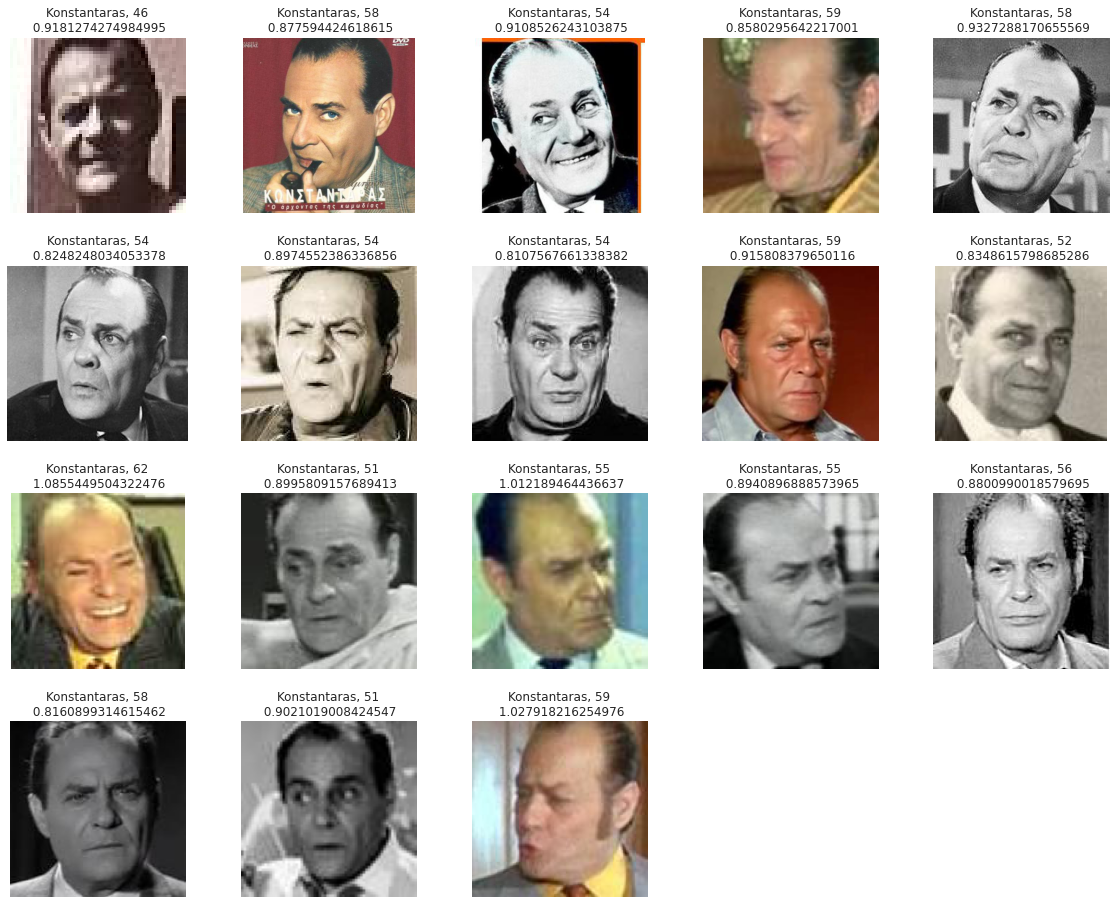

In [ ]:
# Get the name of the first class in the current dataset.
class_name = names[0]

# Retrieve the embeddings of the current class from the dataframe containing all of them.
class_name_embeddings = df.loc[names[0], names[0]] \
                          .replace(0, None) \
                          .groupby(by=df.loc[names[0], names[0]].columns) \
                          .mean() \
                          .values.tolist()[0] 

# Retrieve the image paths given the ids.
class_name_img_paths = get_images(ids=[annotation[0]
                                       for annotation in aligned_images_annotations
                                       if annotation[1] == names[0]])

# Show all of the images with the average distances as extra information in the titles.
show_images(img_paths=class_name_img_paths,
            extra_info=class_name_embeddings)


# References
We report here relevant references:

 1. Moschoglou, S., Papaioannou, A., Sagonas, C., Deng, J., Kotsia, I., & Zafeiriou, S. (2017). AgeDB: The First Manually Collected, In-the-Wild Age Database. In IEEE Computer Society Conference on Computer Vision and Pattern Recognition Workshops (Vols. 2017-July). https://doi.org/10.1109/CVPRW.2017.250
 2. F. Schroff, D. Kalenichenko, J. Philbin. FaceNet: A Unified Embedding for Face Recognition and Clustering, arXiv:1503.03832, 2015. https://arxiv.org/pdf/1503.03832